<a href="https://colab.research.google.com/github/kristin-hub/nn/blob/master/xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Подключаем датасет с гугл диска**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from os import listdir, rename
from os.path import isfile, join

source_dir = 'drive/My Drive/data'
train_dir = 'drive/My Drive/data/train'
validation_dir = 'drive/My Drive/data/validation'
test_dir = 'drive/My Drive/data/test'

fake_dir = 'fake'
orig_dir = 'orig'

images = [f for f in listdir(source_dir) if isfile(join(source_dir, f))]

In [0]:
import numpy as np
import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

np.random.seed(0)
tf.set_random_seed(0)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


**Проверяем включена ли GPU**

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7222712971415576563
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3571975912959636385
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10606964997828769973
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18091890010668009990
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [0]:
train_data_dir = 'drive/My Drive/data/train'
test_data_dir = 'drive/My Drive/data/test'
validation_data_dir = 'drive/My Drive/data/validation'

img_height = 299
img_width = 299

batch_size = 16
epochs = 30

train_first_class = 4112
train_second_class = 4112

val_first_class = 1120
val_second_class = 1120

nb_train_samples = train_first_class + train_second_class
nb_validation_samples = val_first_class + val_second_class


**Прогоняем наш датасет через сверточные слои предобученной сети Xception, чтобы получить признаки и сохраняем их**

In [0]:
from keras.layers import Input
from keras.applications import xception
from keras.preprocessing import image

input_tensor = Input(shape=(img_height,img_width,3))

base_model = xception.Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(img_width, img_height, 3),
                          pooling='avg')


data_generator = image.ImageDataGenerator(rescale=1. / 255)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_train = base_model.predict_generator(
        train_generator, 
        nb_train_samples // batch_size)

print('Prediction of the training set finished.')

np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)

validation_generator = data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_validation = base_model.predict_generator(
        validation_generator, 
        nb_validation_samples // batch_size)

print('Prediction of the validation set finished.')

np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)

Found 8224 images belonging to 2 classes.
Prediction of the training set finished.
Found 2240 images belonging to 2 classes.
Prediction of the validation set finished.


In [0]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = np.array([0] * train_first_class + [1] * train_second_class)

validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array([0] * (val_first_class) + [1] * (val_second_class))

**Создадим полносвязные слои и обучим их на полученных признаках**

In [0]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.layers import Dropout, Dense

model = Sequential()
    
model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))    

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))   

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=SGD(lr=0.005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='top-weights.hdf5', verbose=1, save_best_only=True)

history = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpointer],
                    validation_data=(validation_data, validation_labels))

Train on 8224 samples, validate on 2240 samples
Epoch 1/30
8224/8224 [==============================] - 5s 636us/step - loss: 0.7099 - acc: 0.4996 - val_loss: 0.6857 - val_acc: 0.5518

Epoch 00001: val_loss improved from inf to 0.68568, saving model to top-weights.hdf5
Epoch 2/30
8224/8224 [==============================] - 2s 282us/step - loss: 0.6946 - acc: 0.5253 - val_loss: 0.6816 - val_acc: 0.5906

Epoch 00002: val_loss improved from 0.68568 to 0.68161, saving model to top-weights.hdf5
Epoch 3/30
8224/8224 [==============================] - 2s 279us/step - loss: 0.6873 - acc: 0.5469 - val_loss: 0.6757 - val_acc: 0.6076

Epoch 00003: val_loss improved from 0.68161 to 0.67568, saving model to top-weights.hdf5
Epoch 4/30
8224/8224 [==============================] - 2s 291us/step - loss: 0.6824 - acc: 0.5585 - val_loss: 0.6690 - val_acc: 0.6308

Epoch 00004: val_loss improved from 0.67568 to 0.66898, saving model to top-weights.hdf5
Epoch 5/30
8224/8224 [==============================

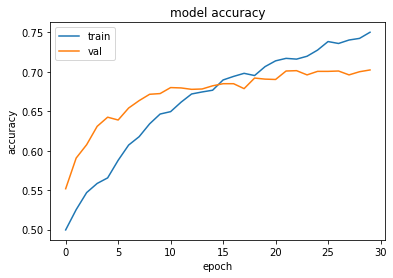

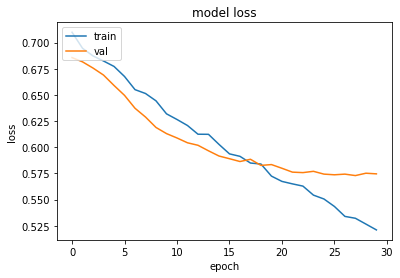

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Объединяем сверточные и полносвязные слои**

In [0]:
from keras.models import Model

batch_size = 16
epochs = 3

input_tensor = Input(shape=(img_height,img_width,3))

base_model = xception.Xception(weights='imagenet',
                                            include_top=False,
                                            input_shape=(img_width, img_height, 3),
                                            pooling='avg')

top_model = Sequential()
    
top_model.add(Dense(256, activation='relu', input_shape=base_model.output_shape[1:]))
top_model.add(Dropout(0.5))

top_model.add(Dense(128, activation='relu'))
top_model.add(Dropout(0.5))  

top_model.add(Dense(64, activation='relu'))
top_model.add(Dropout(0.5))  

top_model.add(Dense(1, activation='sigmoid'))

top_model.load_weights('top-weights.hdf5')

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

model.compile(optimizer=SGD(lr=0.005, momentum=0.1, nesterov=True),
              loss='binary_crossentropy',
              metrics=['accuracy'])


checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

train_datagen = image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

history = model.fit_generator(train_generator,
                            steps_per_epoch=nb_train_samples // batch_size,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=nb_validation_samples // batch_size)

Found 8224 images belonging to 2 classes.
Found 2240 images belonging to 2 classes.
Epoch 1/3
514/514 [==============================] - 299s 582ms/step - loss: 0.5893 - acc: 0.6915 - val_loss: 0.5635 - val_acc: 0.7138
Epoch 2/3
514/514 [==============================] - 285s 555ms/step - loss: 0.5457 - acc: 0.7310 - val_loss: 0.5645 - val_acc: 0.7071
Epoch 3/3
514/514 [==============================] - 288s 561ms/step - loss: 0.5184 - acc: 0.7501 - val_loss: 0.5391 - val_acc: 0.7321


**Тестируем полученную сеть**

In [0]:
test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

score = model.evaluate_generator(test_generator, batch_size)

print("Loss: ", score[0], "Accuracy: ", score[1])

Found 2401 images belonging to 2 classes.
Loss:  0.4482061481103301 Accuracy:  0.8125


**Сохраняем лучшие веса сети**

In [0]:
model.save('fake_orig_v1.h5')